In [1]:
import sys

import importlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlalchemy
import logging

import common
import util
importlib.reload(common)
importlib.reload(util)

from common import create_engine
from common import display_all
from common import figsize
from common import save_df, load_df
from common import save_session, load_session

from util import show_importances
from util import split_X_y_all, split_X_y, split_data
from util import empty_features, column_feature, str_contains

from pbar import Pbar

from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters() # converters e.g. for datetime in plots
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
RANDOM_STATE = 123
np_random = np.random.RandomState(RANDOM_STATE)

In [3]:
df = load_df('final_data.pickle')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20280 entries, 428781 to 812426
Data columns (total 86 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   title                    20280 non-null  object        
 1   perex                    16137 non-null  object        
 2   body                     20246 non-null  object        
 3   published_at             20280 non-null  datetime64[ns]
 4   extracted_at             20280 non-null  datetime64[ns]
 5   category                 13716 non-null  object        
 6   other_info               20276 non-null  object        
 7   image_count              20280 non-null  int64         
 8   video_count              20280 non-null  int64         
 9   author_name              20280 non-null  object        
 10  source_id                20280 non-null  int64         
 11  source_name              20280 non-null  object        
 12  source_url               2

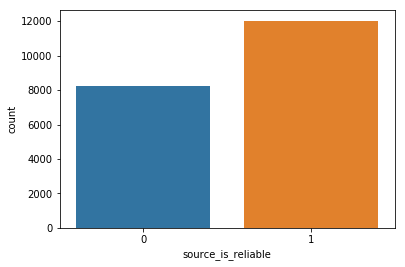

In [5]:
sns.countplot(data=df,
             x='source_is_reliable')

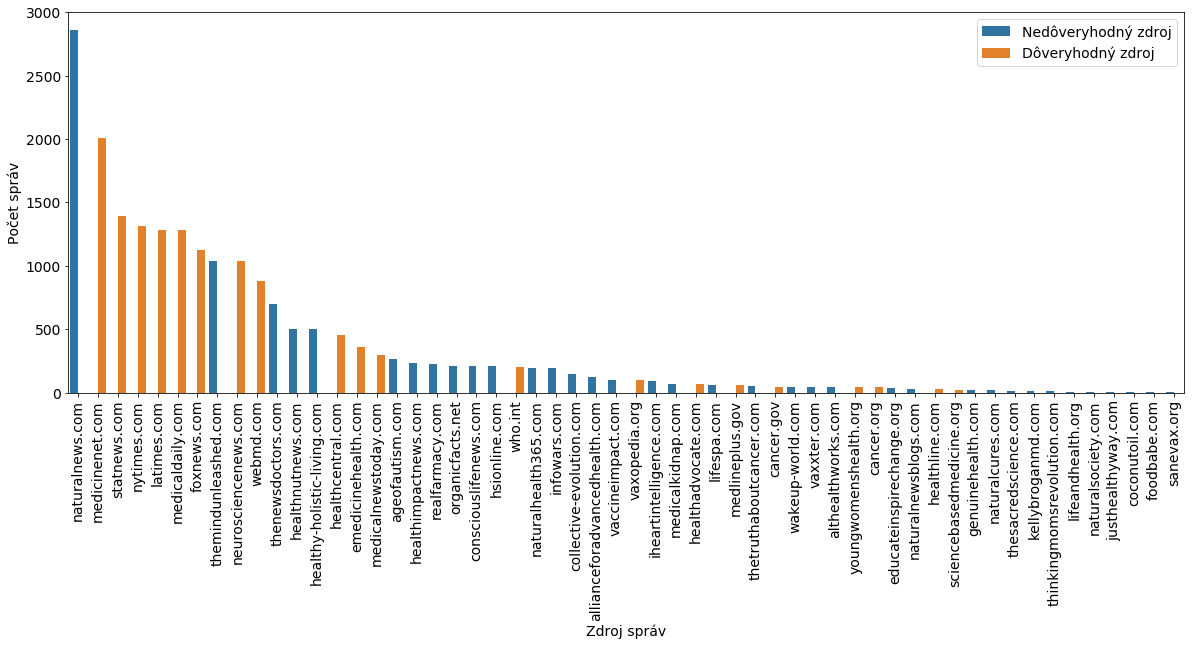

In [6]:
plt.figure(figsize=(20,7))
plt.rcParams.update({'font.size': 14})

ax = sns.countplot(data=df,
              x='source_name', 
              hue='source_is_reliable', 
              order=df.source_name.value_counts().index)

ax.set(xlabel='Zdroj správ', ylabel='Počet správ')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.legend(['Nedôveryhodný zdroj', 'Dôveryhodný zdroj'], loc="upper right")
ax.get_figure().savefig('export/zdroje-doveryhodnost.png', bbox_inches = "tight")

In [50]:
df.groupby('source_name')['source_is_reliable'].unique().apply(lambda x: x[0])

source_name
ageofautism.com                  0
allianceforadvancedhealth.com    0
althealthworks.com               0
cancer.gov                       1
cancer.org                       1
coconutoil.com                   0
collective-evolution.com         0
consciouslifenews.com            0
educateinspirechange.org         0
emedicinehealth.com              1
foodbabe.com                     0
foxnews.com                      1
genuinehealth.com                0
healthadvocate.com               1
healthcentral.com                1
healthimpactnews.com             0
healthline.com                   1
healthnutnews.com                0
healthy-holistic-living.com      0
hsionline.com                    0
iheartintelligence.com           0
infowars.com                     0
justhealthyway.com               0
kellybroganmd.com                0
latimes.com                      1
lifeandhealth.org                0
lifespa.com                      0
medicaldaily.com                 1
medicalk

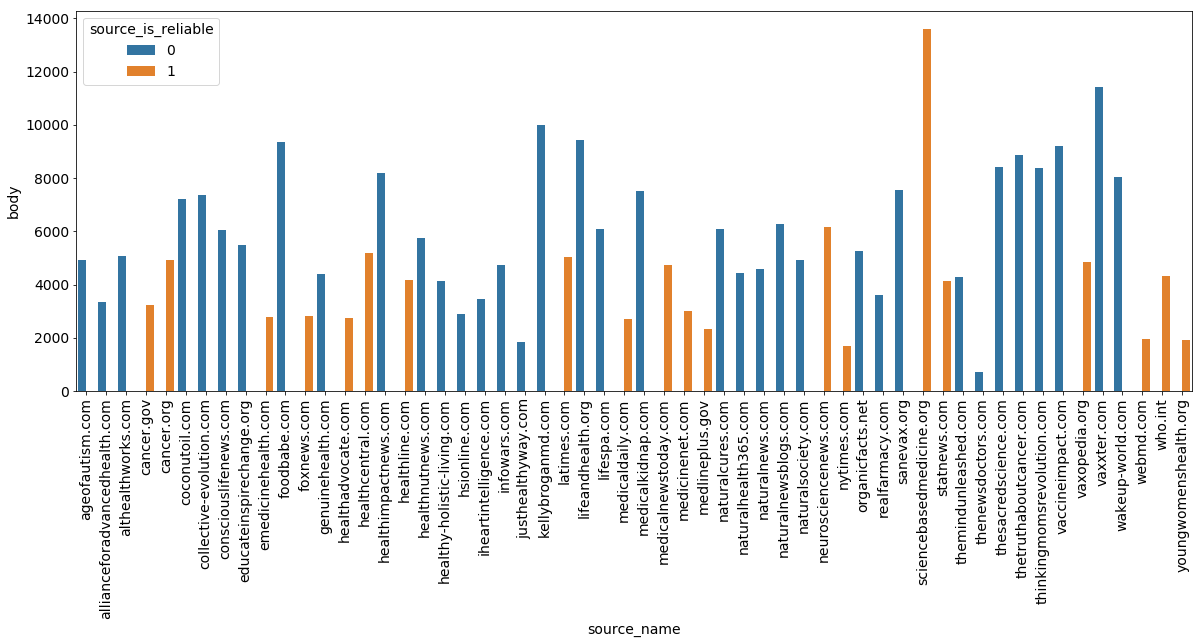

In [55]:
x = pd.DataFrame([
    df.groupby('source_name')['body'].apply(lambda x: np.mean(x.str.len()))
]).transpose()
x['source_is_reliable'] = df.groupby('source_name')['source_is_reliable'].unique().apply(lambda x: x[0])
plt.figure(figsize=(20,7))
x = x.reset_index()

ax = sns.barplot(data=x, x='source_name', y='body', hue='source_is_reliable')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax

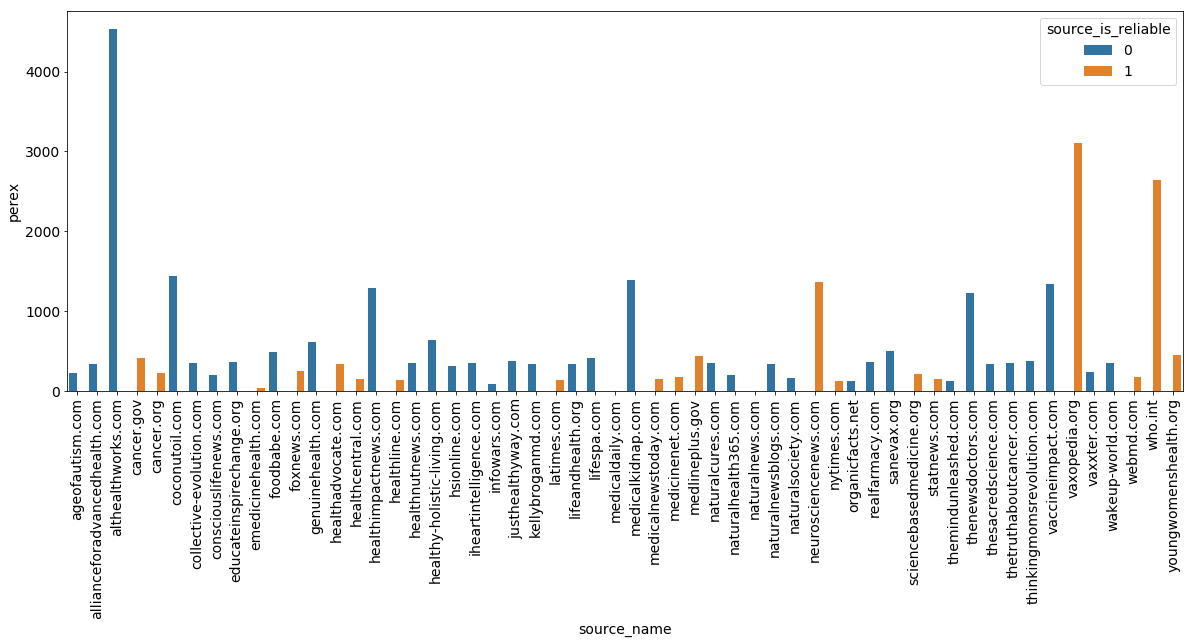

In [56]:
x = pd.DataFrame([
    df.groupby('source_name')['perex'].apply(lambda x: np.mean(x.str.len()))
]).transpose()
x['source_is_reliable'] = df.groupby('source_name')['source_is_reliable'].unique().apply(lambda x: x[0])
plt.figure(figsize=(20,7))
x = x.reset_index()

ax = sns.barplot(data=x, x='source_name', y='perex', hue='source_is_reliable')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax

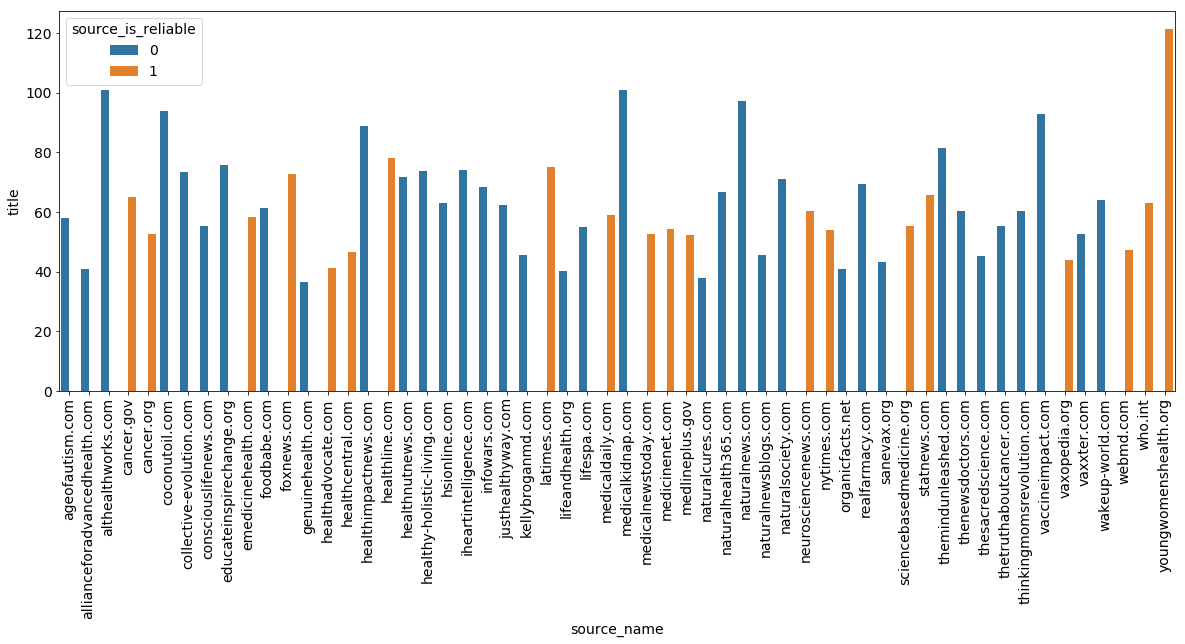

In [57]:
x = pd.DataFrame([
    df.groupby('source_name')['title'].apply(lambda x: np.mean(x.str.len()))
]).transpose()
x['source_is_reliable'] = df.groupby('source_name')['source_is_reliable'].unique().apply(lambda x: x[0])
plt.figure(figsize=(20,7))
x = x.reset_index()

ax = sns.barplot(data=x, x='source_name', y='title', hue='source_is_reliable')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax

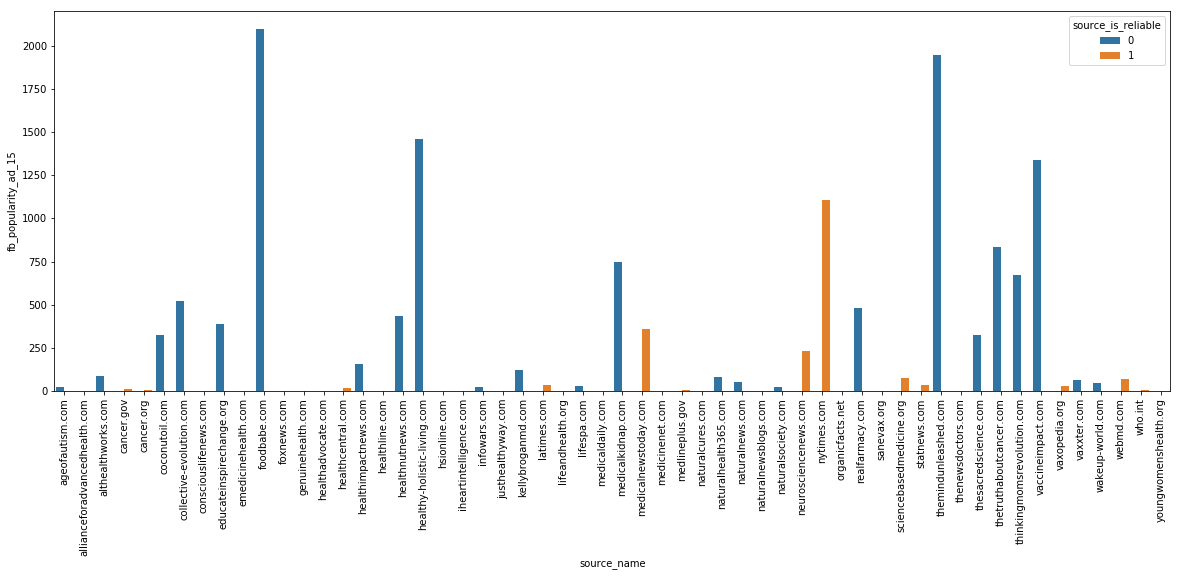

In [9]:
x = pd.DataFrame([
    df.groupby('source_name')['fb_popularity_ad_15'].apply(lambda x: np.median(x))
]).transpose()
x['source_is_reliable'] = df.groupby('source_name')['source_is_reliable'].unique().apply(lambda x: x[0])
plt.figure(figsize=(20,7))
x = x.reset_index()

ax = sns.barplot(data=x, x='source_name', y='fb_popularity_ad_15', hue='source_is_reliable')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax

In [12]:
df.source_name.value_counts()

naturalnews.com                  2858
medicinenet.com                  2007
statnews.com                     1394
nytimes.com                      1315
latimes.com                      1281
medicaldaily.com                 1279
foxnews.com                      1122
themindunleashed.com             1041
neurosciencenews.com             1035
webmd.com                         876
thenewsdoctors.com                696
healthnutnews.com                 501
healthy-holistic-living.com       500
healthcentral.com                 451
emedicinehealth.com               358
medicalnewstoday.com              298
ageofautism.com                   264
healthimpactnews.com              230
realfarmacy.com                   225
organicfacts.net                  213
consciouslifenews.com             207
hsionline.com                     206
who.int                           204
naturalhealth365.com              195
infowars.com                      193
collective-evolution.com          145
alliancefora

--

1. popularita clankov (oktober vs dnes)
2. analyzovat rozlozenie popularity v dnoch
3. pozriet sa na pocty pre reliable a unreliable

1. pocet clankov
2. zdroje
3. 